In [62]:
import orekit
import numpy as np

vm = orekit.initVM()
print ('Java version:',vm.java_version)
print ('Orekit version:', orekit.VERSION)

from orekit.pyhelpers import setup_orekit_curdir, download_orekit_data_curdir
setup_orekit_curdir()

from org.orekit.utils import Constants

from scenarios.utils.utility import get_vel, get_vels, get_apo, rocket_equation, mass_fraction


Java version: 1.8.0_382
Orekit version: 12.0.1
File or folder: /home/chris/git/space/src/orekit-data.zip  not found


        The Orekit library relies on some external data for physical models. 
        Typical data are the Earth Orientation Parameters and the leap seconds history, 
        both being provided by the IERS or the planetary ephemerides provided by JPL. 
        Such data is stored in text or binary files with specific formats that Orekit knows 
        how to read, and needs to be provided for the library to work.

        You can download a starting file with this data from the orekit gitlab at:
        https://gitlab.orekit.org/orekit/orekit-data

        or by the function:
        orekit.pyhelpers.download_orekit_data_curdir()

        


In [63]:

###

RE = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
MU = Constants.WGS84_EARTH_MU

print(f'using Constants.WGS84_EARTH_EQUATORIAL_RADIUS {Constants.WGS84_EARTH_EQUATORIAL_RADIUS} as RE')
print(f'using Constants.WGS84_EARTH_MU {Constants.WGS84_EARTH_MU} as MU')

g_test = MU / RE**2

print(f'g (m/s^2) = {g_test}')


## TODO: Reconsider MUs ?

MU_JPL = Constants.JPL_SSD_EARTH_GM

print(f'mu = {MU}')
print(f'mu_jpl = {MU_JPL}')
print(f'mu - mujpl = {MU - MU_JPL}')

RM = Constants.MOON_EQUATORIAL_RADIUS


using Constants.WGS84_EARTH_EQUATORIAL_RADIUS 6378137.0 as RE
using Constants.WGS84_EARTH_MU 398600441800000.0 as MU
g (m/s^2) = 9.7982854791873
mu = 398600441800000.0
mu_jpl = 398600436738211.56
mu - mujpl = 5061788.4375


In [73]:
###

h_leo = 185e3 # m
h_geo = 36000e3 # m

R_leo = h_leo + RE
R_geo = h_geo + RE

v_geo = get_vel( R_geo, R_geo, MU )

print(f'v_geo (km/s) = {v_geo/1000}')

(vp_gto,va_gto) = get_vels( R_leo, R_geo, MU )

print(f'vp_gto (km/s) = {vp_gto/1000}, va_gto (km/s) = {va_gto/1000}')

dv_gto2geo = v_geo - va_gto
print(f'DV GTO 2 GEO = v_geo - va_gto (m/s) = {dv_gto2geo}')


v_inf_leo = np.sqrt( 2*MU/R_leo)
v_inf_geo = np.sqrt( 2*MU/R_geo)

print(f'v_inf_leo (km/s) = {v_inf_leo/1000}, v_inf_geo (km/s) = {v_inf_geo/1000}')

R = get_apo( R_leo, vp_gto + 600, MU )
print(f'R = {(R - RE)/1000} (km)')


v_geo (km/s) = 3.066888291825575
vp_gto (km/s) = 10.255608789236996, va_gto (km/s) = 1.588294584591261
DV GTO 2 GEO = v_geo - va_gto (m/s) = 1478.5937072343138
v_inf_leo (km/s) = 11.021181403983277, v_inf_geo (km/s) = 4.337235016582982
R = 207146.37047889634 (km)
R_geo = 42378.137 (km)


In [72]:
MU_L = Constants.JPL_SSD_MOON_GM

# https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
RE_MP = 363104e3
RE_MA = 405696e3
RE_M = np.mean([RE_MA,RE_MP])
print(f'RE_M (km) = {RE_M/1000}')


# TODO: check me: apogee of low earth LTI orbit
R_a_LTI = 384400e3

(vp_lti,va_lti) = get_vels( R_leo, R_a_LTI, MU )

print(f'vp_lti (km/s) = {vp_lti/1000}, va_lti (km/s) = {va_lti/1000}')

dv_gto2lti = vp_lti - vp_gto
print(f'DV GTO 2 LTI = vp_lti - vp_gto (m/s) = {dv_gto2lti}')


v_fmoon = get_vel( RE_M, RE_M, MU )
T_moon = 27.32*86400
v_moon = RE_M * (2*np.pi/T_moon)
print(f'V_FAKE (km) = {v_fmoon/1000}')
print(f'V_M (km) = {v_moon/1000}')



RE_M (km) = 384400.0
vp_lti (km/s) = 10.928283047140303, va_lti (km/s) = 0.18658641730790695
DV GTO 2 LTI = vp_lti - vp_gto (m/s) = 672.6742579033071
V_FAKE (km) = 1.0183034106336974
V_M (km) = 1.023219504127959


In [66]:
### GEO to Lunar Transfer (2.5km/s from bard = .7 circ + 1.3 raise + .5 inc)


(vp_geo2lti,va_geo2lti) = get_vels( h_geo+RE, R_a_LTI, MU )

print(f'vp_geo2lti (km/s) = {vp_geo2lti/1000}, va_geo2lti (km/s) = {va_geo2lti/1000}')

dv_geo2lti = vp_geo2lti - v_geo

print(f'DV GEO 2 LTI = vp_geo2lti - v_geo (m/s) = {dv_geo2lti}')



vp_geo2lti (km/s) = 4.116267245518918, va_geo2lti (km/s) = 0.45379744344228246
DV GEO 2 LTI = vp_geo2lti - v_geo (m/s) = 1049.3789536933427


In [67]:
### Lunar Capture (640 m/s from bard to 100 km circ [+ 120 m/s for direct transfers])
# : (chatGPT says 1.5 - 2 km/s)

dv_lti2llo = 760

h_llo = 100e3

v_llo = get_vel( h_llo+RM, h_llo+RM, MU_L )

(vp_l2s,va_l2s) = get_vels( RM, h_llo+RM, MU_L )

# https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
print(f'moon radius = {RM}')
print(f'MU_L (m^3/s^2) = {MU_L*10**-12} *10^12')
print(f'MU (Gkm^3/s^2) = {MU * 10**-9 * 10**-6}, MU_L (Gkm^3/s^2) = {MU_L * 10**-9 * 10**-6}')
print(f'escape velocity = 2.38 km/s (11.2 for earth)')
v_ls = 0 # once every 30 days right ?

# Sidereal rotation period (hrs)	655.720
w_L = 2*np.pi / (655.72*3600)
v_ls = w_L * RM

print(f'v_ls = {v_ls}')
print(f'vp_l2s = {vp_l2s}')
print(f'va_l2s = {va_l2s}')
print(f'v_llo = {v_llo}')

dv_ls2l2s = vp_l2s - v_ls
print(f'DV LS 2 L2S = vp_l2s - v_ls (m/s) = {dv_ls2l2s}')

dv_l2s2llo = v_llo - va_l2s
print(f'DV L2S 2 LLO = v_llo - va_l2s (m/s) = {dv_l2s2llo}')

print(f'RM (km) = {RM/1000}')


# Low-Dv
dv_gto2geo = 0
dv_lti2llo = 900
dv_geo2lti = 0

# Ideal
dv_gto2geo = 0
dv_lti2llo = 700
dv_geo2lti = 1300

# Realizable
dv_gto2geo = 700
dv_lti2llo = 900
dv_geo2lti = 1300

print(f'GTO 2 GEO : {dv_gto2geo:10.0f} \t raise')
print(f'GEO 2 LTI : {dv_geo2lti:10.0f} \t lunar injection')
print(f'LTI 2 LLO : {dv_lti2llo:10.0f} \t lunar orbit capture')
print(f'LLO 2 L2S : {dv_l2s2llo:10.0f} \t lunar descent burn')
print(f'L2S 2 LS  : {dv_ls2l2s:10.0f} \t lunar landing burn')



moon radius = 1737400.0
MU_L (m^3/s^2) = 4.902798458429648 *10^12
MU (Gkm^3/s^2) = 0.39860044180000004, MU_L (Gkm^3/s^2) = 0.004902798458429647
escape velocity = 2.38 km/s (11.2 for earth)
v_ls = 4.624435799449381
vp_l2s = 1703.1899706600493
va_l2s = 1610.4943153503698
v_llo = 1633.5038575843078
DV LS 2 L2S = vp_l2s - v_ls (m/s) = 1698.5655348605999
DV L2S 2 LLO = v_llo - va_l2s (m/s) = 23.009542233937964
RM (km) = 1737.4
GTO 2 GEO :          0 	 raise
GEO 2 LTI :          0 	 lunar injection
LTI 2 LLO :        900 	 lunar orbit capture
LLO 2 L2S :         23 	 lunar descent burn
L2S 2 LS  :       1699 	 lunar landing burn


In [69]:

# Isp = 350 # Lox Methane
Isp = 450
g0 = 9.8
m_spacecraft = 10e3
# m_dump = 10e3
m_dump = np.linspace(0, 20e3, num=10)

m_l2s2ls = m_spacecraft * mass_fraction( dv_ls2l2s, Isp, g0 )
print(f'm_l2s2ls = {m_l2s2ls}')

m_llo_return = m_l2s2ls * mass_fraction( dv_l2s2llo, Isp, g0 )
print(f'm_llo = {m_llo_return}')

m_lti2llo = m_llo_return * mass_fraction( dv_lti2llo, Isp, g0 )
print(f'm_lti2llo = {m_lti2llo}')

m_gto2geo = m_lti2llo * mass_fraction( dv_geo2lti, Isp, g0 )
print(f'm_gto2geo = {m_gto2geo}')

m_gto_return = m_gto2geo * mass_fraction( dv_gto2geo, Isp, g0 )
print(f'm_gto_return = {m_gto_return}')

m_gto_arrive = m_gto_return + m_dump
print(f'm_gto_arrive = {m_gto_arrive}')

m_geo2gto = m_gto_arrive * mass_fraction( dv_gto2geo, Isp, g0 )
print(f'm_geo2gto = {m_geo2gto}')

m_lti2geo = m_geo2gto * mass_fraction( dv_geo2lti, Isp, g0 )
print(f'm_lti2geo = {m_lti2geo}')

m_llo_depart = m_lti2geo * mass_fraction( dv_lti2llo, Isp, g0 )
print(f'm_llo_depart = {m_llo_depart}')

m_l2s = m_llo_depart * mass_fraction( dv_l2s2llo, Isp, g0 )
print(f'm_l2s = {m_l2s}')

m_ls = m_l2s * mass_fraction( dv_ls2l2s, Isp, g0 )
print(f'm_ls = {m_ls}')



m_l2s2ls = 14698.527898294762
m_llo = 14775.419110310315
m_lti2llo = 18120.548339576002
m_gto2geo = 18120.548339576002
m_gto_return = 18120.548339576002
m_gto_arrive = [18120.54833958 20342.7705618  22564.99278402 24787.21500624
 27009.43722846 29231.65945069 31453.88167291 33676.10389513
 35898.32611735 38120.54833958]
m_geo2gto = [18120.54833958 20342.7705618  22564.99278402 24787.21500624
 27009.43722846 29231.65945069 31453.88167291 33676.10389513
 35898.32611735 38120.54833958]
m_lti2geo = [18120.54833958 20342.7705618  22564.99278402 24787.21500624
 27009.43722846 29231.65945069 31453.88167291 33676.10389513
 35898.32611735 38120.54833958]
m_llo_depart = [22223.00901758 24948.33849205 27673.66796653 30398.997441
 33124.32691548 35849.65638996 38574.98586443 41300.31533891
 44025.64481338 46750.97428786]
m_l2s = [22339.26243491 25078.84870353 27818.43497215 30558.02124077
 33297.60750938 36037.193778   38776.78004662 41516.36631524
 44255.95258385 46995.53885247]
m_ls = [32835.427

In [70]:
###


m_spacecraft = m_l2s2ls
m_burned = m_ls - m_dump - m_spacecraft

mass_ratio = m_burned / (m_burned + m_spacecraft)
print(f'm_spacecraft = {m_spacecraft}')
print(f'm_burned = {m_burned}')
print(f'm_dump = {m_dump}')
print(f'm_burned / (m_burned + m_spacecraft) = {m_burned / (m_burned + m_spacecraft)}')

print(f'm_burned / (m_burned + m_dump) = {m_burned / (m_burned + m_dump)}')


m_spacecraft = 14698.527898294762
m_burned = [18136.8993144  19941.46561208 21746.03190976 23550.59820745
 25355.16450513 27159.73080281 28964.2971005  30768.86339818
 32573.42969586 34377.99599355]
m_dump = [    0.          2222.22222222  4444.44444444  6666.66666667
  8888.88888889 11111.11111111 13333.33333333 15555.55555556
 17777.77777778 20000.        ]
m_burned / (m_burned + m_spacecraft) = [0.55235765 0.57567752 0.59668801 0.61571598 0.63302939 0.64884999
 0.66336287 0.67672375 0.68906454 0.70049778]
m_burned / (m_burned + m_dump) = [1.         0.8997359  0.83030303 0.77937558 0.74042533 0.70967163
 0.68477352 0.66420398 0.6469245  0.63220417]


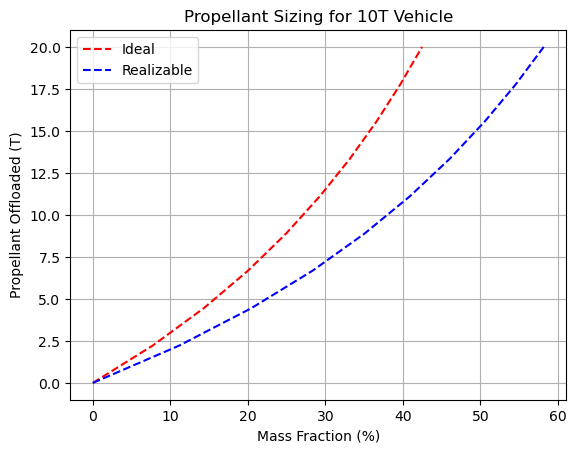

In [71]:
m_burned_ideal = np.asarray([26494.35103807, 28782.35746169, 31070.3638853, 33358.37030891, 35646.37673253, 37934.38315614, 40222.38957975, 42510.39600336, 44798.40242698, 47086.40885059])
m_dump_ideal = np.asarray([    0, 2222.22222222,  4444.44444444,  6666.66666667,  8888.88888889, 11111.11111111, 13333.33333333, 15555.55555556, 17777.77777778, 20000.        ])

import matplotlib.pyplot as plt

# Plotting
# plt.plot( m_burned/1000, m_dump/1000, marker='o', linestyle='-' )
# plt.xlabel('Propellant Burned (T)')

plt.plot( m_dump_ideal / m_burned_ideal * 100, m_dump_ideal/1000, marker=None, linestyle='--', color='r' )
plt.plot( m_dump / m_burned * 100, m_dump/1000, marker=None, linestyle='--', color='b' )
plt.xlabel('Mass Fraction (%)')
plt.legend(['Ideal','Realizable'])
# Adding labels and title
plt.ylabel('Propellant Offloaded (T)')
title = 'Propellant Sizing for 10T Vehicle'
plt.title(title)
plt.grid()

# Display the plot
plt.savefig(title.replace(' ','_') + '.png')
plt.show()


